## Laboratorium 8.2

## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---


### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:

```python
fps = source.get(cv2.CAP_PROP_FPS)
```

Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).


In [1]:
from icecream import ic
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.


In [2]:
file_path = 'data/dane8/shuttle.mp4'

In [3]:
def get_frames(file_path, skip_frames=0):

    cap = cv2.VideoCapture(file_path)
    status, frame = cap.read()

    if not status:
        raise ValueError("Failed to read the first frame from the video.")

    for _ in range(skip_frames):
        status, _ = cap.read()
        if not status:
            raise ValueError("Failed to read the frame after skipping.")

    _, frame1 = cap.read()
    _, frame2 = cap.read()

    cap.release()

    return frame1, frame2

In [4]:
@dataclass
class ROI:
    x: int
    y: int
    width: int
    height: int

In [5]:

def draw_roi(frame, roi):
    frame_copy = frame.copy()
    cv2.rectangle(frame_copy, (roi.x, roi.y), (roi.x+roi.width, roi.y+roi.height), (0, 0, 255), 4)
    plt.figure(figsize=(10, 10))
    plt.imshow(frame_copy[..., ::-1])
    plt.show()

In [6]:
def detect_features(frame, roi, max_corners=100, quality_level=0.3, min_distance=7):
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    roi_gray = gray[roi.y:roi.y+roi.height, roi.x:roi.x+roi.width]
    
    corners = cv2.goodFeaturesToTrack(
        roi_gray,
        maxCorners=max_corners,
        qualityLevel=quality_level,
        minDistance=min_distance,
        blockSize=7
    )
    # correct coordinates
    if corners is not None:
        corners[:, 0, 0] += roi.x
        corners[:, 0, 1] += roi.y
        
    return corners

In [7]:
def visualize_keypoints(frame, keypoints):
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if keypoints is not None:
        for corner in keypoints:
            x, y = corner.ravel()
            plt.plot(x, y, 'r.')
    plt.title(f'Detected {len(keypoints)} features')
    plt.axis('off')
    plt.show()

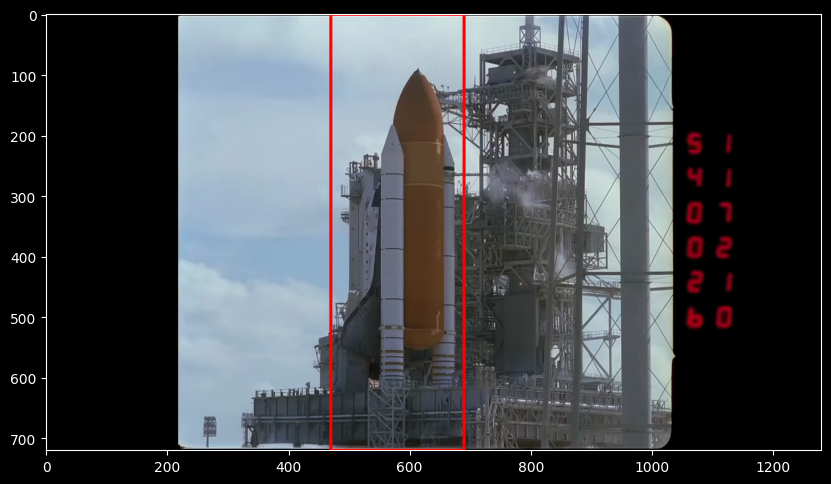

In [8]:
frame, _ = get_frames(file_path)

roi = ROI(
    x=470, 
    y=0, 
    width=220, 
    height=frame.shape[0]
)
draw_roi(frame, roi)

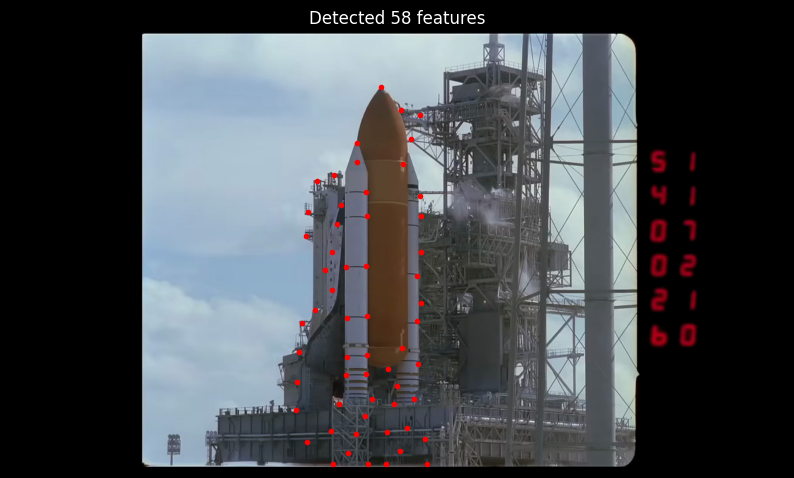

In [9]:
corners = detect_features(frame, roi, max_corners=100, quality_level=0.01, min_distance=30)

visualize_keypoints(frame, corners)

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).


In [10]:
def get_video_properties(file_path):
    cap = cv2.VideoCapture(file_path)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = int(cap.get(cv2.CAP_PROP_FPS))
    cap.release()
    return width, height, fps

WIDTH, HEIGHT, FPS = get_video_properties(file_path)

In [11]:
def track_features(video_path, roi, output_path, max_frames=None, window_size=5, movement_threshold=0.5):

    cap = cv2.VideoCapture(video_path)  # reading input video

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, FPS, (WIDTH, HEIGHT)) # writing output video
    
    status, first_frame = cap.read()
    if not status:
        raise ValueError("Failed to read the first frame from the video.")
    
    old_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    
    p0 = detect_features(first_frame, roi, max_corners=100, quality_level=0.01, min_distance=30)
    
    if p0 is None:
        cap.release()
        out.release()
        return
    
    trajectories = [[] for _ in range(len(p0))] 
    point_moved = [False] * len(p0)
    
    frame_count = 0
    
    while True:
        
        status, frame = cap.read()
        if not status:
            break
            
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None)
        
        good_new = p1[st==1]

        # draw ROI
        cv2.rectangle(frame, (roi.x, roi.y), (roi.x+roi.width, roi.y+roi.height), (0, 0, 255), 2)


        for i, new in enumerate(good_new):
            x_new, y_new = new.ravel()
            
            if roi.x <= x_new <= roi.x + roi.width:
                if len(trajectories[i]) >= window_size:
                    old_pos = trajectories[i][-window_size]
                    distance = np.sqrt((old_pos[0] - x_new)**2 + (old_pos[1] - y_new)**2)
                    if distance > movement_threshold:
                        point_moved[i] = True
                
                trajectories[i].append((x_new, y_new))
                
                if point_moved[i]:
                    if len(trajectories[i]) > 1:
                        for j in range(1, len(trajectories[i])):
                            pt1 = tuple(map(int, trajectories[i][j-1]))
                            pt2 = tuple(map(int, trajectories[i][j]))
                            cv2.line(frame, pt1, pt2, (0, 255, 0), 1)
                    
                    cv2.circle(frame, (int(x_new), int(y_new)), 3, (0, 0, 255), -1) # draw current point
        
        out.write(frame) # write frame to video
        
        # update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
        
        frame_count += 1
        if max_frames and frame_count >= max_frames:
            break
    
    cap.release()
    out.release()
    ic(frame_count)
    
    # filter out trajectories of points that never moved more than movement_threshold
    filtered_trajectories = [traj for traj, moved in zip(trajectories, point_moved) if moved]
    
    return filtered_trajectories

In [12]:
def plot_trajectories_on_frame(trajectories, frame_shape, roi, threshold=2):

    frame, _ = get_frames(file_path, 200)
    
    plt.figure(figsize=(10,10))
    
    if frame is not None:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
    
    plt.xlim(0, frame_shape[1])
    plt.ylim(frame_shape[0], 0) # inverted y-axis to match image coordinates
    
    for trajectory in trajectories:
        trajectory = np.array(trajectory)
        distances = np.sqrt(np.sum(np.diff(trajectory, axis=0)**2, axis=1))
        
        if np.any(distances > threshold):
            plt.plot(trajectory[0, 0], trajectory[0, 1], 'ro', markersize=2)    
            plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=2)  
            plt.plot(trajectory[1:-1, 0], trajectory[1:-1, 1], 'g-', linewidth=1, alpha=0.5)

    # Draw ROI boundaries
    plt.axvline(x=roi.x, color='r', alpha=0.5)
    plt.axvline(x=roi.x+roi.width, color='r', alpha=0.5)
    
    plt.title('Feature Trajectories')
    plt.grid(True, alpha=0.3)
    plt.axis('off')
    plt.show()

ic| frame_count: 200


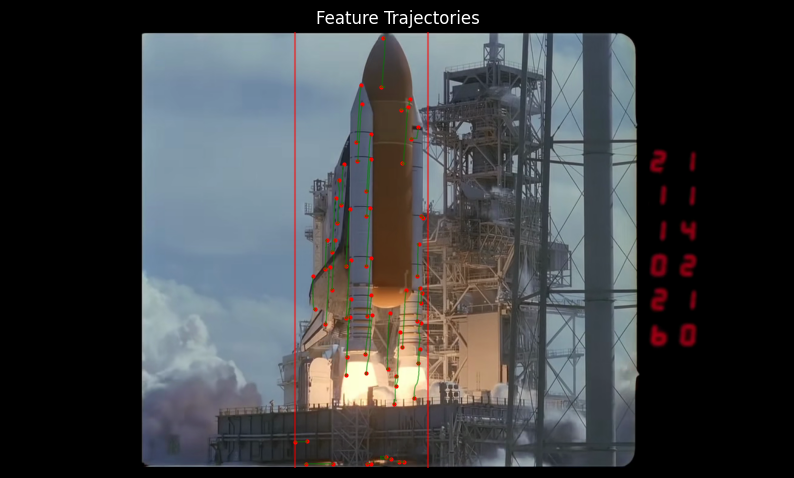

In [13]:
output_path = 'output/shuttle_tracked.mp4'
trajectories = track_features(file_path, roi, output_path, max_frames=200, window_size=5, movement_threshold=2.0)

plot_trajectories_on_frame(trajectories, (HEIGHT, WIDTH), roi)

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.


#### Bazując na tym obrazku, przyjmę że wysokość to 56m.

![alt text](https://lh6.googleusercontent.com/proxy/yubDfB6X6Va5Y-IaoedSsYZmJwdUq6BFXF_vzyYUC_Om16OF-nJcDXiePdpDT6sSnN-0uKgouHUpgOYdwFndHwhSvpuphzWHkcAq6XE "Title")


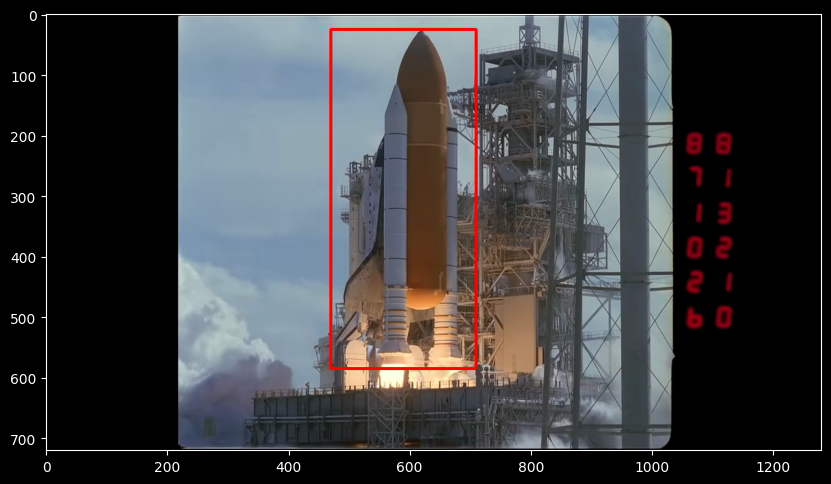

In [14]:
file_path = 'data/dane8/shuttle.mp4'
frame, _ = get_frames(file_path, 190)

roi = ROI(
    x=470, 
    y=25, 
    width=240, 
    height=560
)

draw_roi(frame, roi)

Rzeczywista wysokość `56m` z pewnym przybliżeniem przekłada się na `560px` w przestrzeni obrazu, więc przyjmuję `1px = 0.1m`


In [15]:
def calculate_total_distance(trajectory):
    points = np.array(trajectory)
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
    return np.sum(distances)


def filter_trajectories(trajectories, min_distance=100):
    distances = [calculate_total_distance(traj) for traj in trajectories]
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    
    # keep trajectories within 1 standard deviation of the mean distance
    filtered = [traj for traj, dist in zip(trajectories, distances) 
        if abs(dist - mean_dist) < std_dist and dist > min_distance]
    
    return filtered

Left 15 out of 44 trajectories


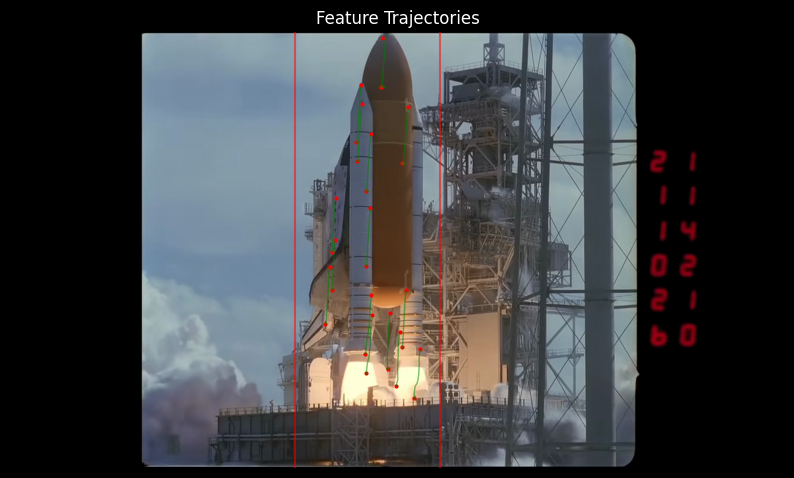

In [16]:
filtered_trajectories = filter_trajectories(trajectories, min_distance=100)
print(f"Left {len(filtered_trajectories)} out of {len(trajectories)} trajectories")
plot_trajectories_on_frame(filtered_trajectories, frame.shape, roi)

In [17]:
def apply_moving_average_smoothing(trajectory, window_size=5):
    trajectory = np.array(trajectory)
    smoothed = np.zeros_like(trajectory, dtype=float)
    
    for i in range(len(trajectory)):
        start = max(0, i - window_size // 2)
        end = min(len(trajectory), i + window_size // 2 + 1)
        smoothed[i] = np.mean(trajectory[start:end], axis=0)
    
    return smoothed


def calculate_velocities(trajectories, pixels_per_meter=10, window_size=5):
    all_velocities = []
    times = []
    
    for trajectory in trajectories:
        # Smooth the trajectory
        smoothed = apply_moving_average_smoothing(trajectory, window_size)
        
        # Calculate velocities between consecutive points
        distances = np.sqrt(np.sum(np.diff(smoothed, axis=0)**2, axis=1))
        velocities = distances * FPS / pixels_per_meter  # Convert to m/s
        
        # Create time points (starting from 0)
        time_points = np.arange(len(velocities)) / FPS
        
        all_velocities.append(velocities)
        times.append(time_points)
    
    return times, all_velocities

In [37]:
def plot_velocity_analysis(times, velocities, window_size=5):
    plt.figure(figsize=(12, 6))
    
    # Plot individual trajectories
    for i, (time, vel) in enumerate(zip(times, velocities)):
        if i == 0:
            plt.plot(time, vel, 'b-', alpha=0.2, label='Raw measurements')
        else:
            plt.plot(time, vel, 'b-', alpha=0.2)
    
    # Calculate and plot average velocity
    max_len = min(len(v) for v in velocities)
    aligned_velocities = [v[:max_len] for v in velocities]
    avg_velocity = np.mean(aligned_velocities, axis=0)
    avg_time = times[0][:max_len]
    
    
    smoothed_avg = np.convolve(avg_velocity, np.ones(window_size)/window_size, mode='valid')
    smoothed_time = avg_time[window_size-1:]
    
    plt.plot(smoothed_time, smoothed_avg, 'orange', linewidth=2, label='Smoothed Average Velocity')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Shuttle Velocity Over Time')
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()
    
    mean_velocity_m_s = np.mean(smoothed_avg)
    peak_velocity_m_s = np.max(smoothed_avg)
    mean_velocity_km_h = mean_velocity_m_s * 3.6
    peak_velocity_km_h = peak_velocity_m_s * 3.6
    print(f"Average velocity: {mean_velocity_km_h:.2f} km/h")
    print(f"Peak velocity: {peak_velocity_km_h:.2f} km/h")

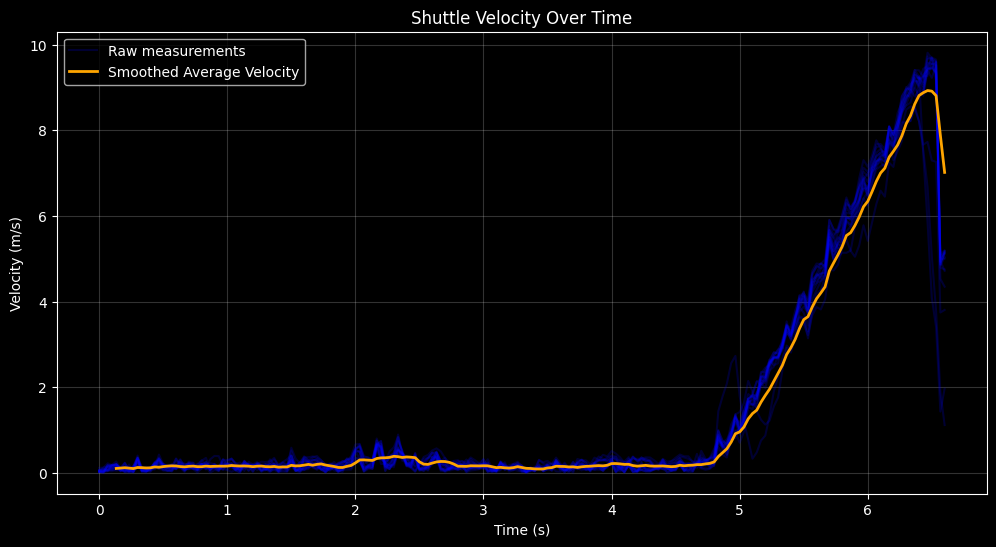

Average velocity: 5.17 km/h
Peak velocity: 32.14 km/h


In [38]:
smoothing_window_size = 5

times, velocities = calculate_velocities(filtered_trajectories, pixels_per_meter=10, window_size=smoothing_window_size)
plot_velocity_analysis(times, velocities, window_size=smoothing_window_size)